# YOLO Models Notebook

#### This notebook contains:

####1. The Object Detection + Classification YOLO model trained on Cars Classification  which will draw bounding boxes AND label car classification in the Lyft Dashcam Dataset

####2. The Object Detection Only YOLO model trained on Lyft dashcam data labeled in RoboFlow to simply draw bounding boxes around Lyft dashcam images

# Initial Installs and Mounting Drive

In [ ]:
pip install --upgrade ultralytics

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, silhouette_score
from google.colab import drive
from ultralytics import YOLO
from PIL import Image, ImageFile
from sklearn.model_selection import train_test_split
import cv2
import shutil
import random
from matplotlib.patches import Rectangle
from pycocotools.coco import COCO
from pycocotools.coco import COCO as COCO80 # Rename imported module to avoid conflict with variable name


In [ ]:
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
root_dir = "/content/drive/Shareddrives/ADSP Computer Vision Summer '24 Group 2/Car Data"
os.chdir(root_dir)

In [ ]:
from glob import glob

images = glob("train/images/suv_crossover/**/*.*", recursive=True)
print(f"We have {len(images):,.0f} images")

We have 960 images


# Convert the Labels in Car Dataset to YOLO Format

In [ ]:
drive_path = "/content/drive/Shareddrives/ADSP Computer Vision Summer '24 Group 2/Car Data"
images_path = os.path.join(drive_path, 'sample_balanced')
labels_path = os.path.join(drive_path, 'labels_balanced')

In [ ]:
class_names = [name for name in os.listdir(images_path) if os.path.isdir(os.path.join(images_path, name))]
class_to_index = {name: i for i, name in enumerate(class_names)}

In [ ]:
class_names

['sports_convertible',
 'hatchback',
 'mini_van',
 'pickup',
 'minibus',
 'station_wagon',
 'sedan',
 'suv_crossover']

In [ ]:
#process labels to yolo format

In [ ]:
def convert_to_yolo_format(xmin, ymin, xmax, ymax, img_width, img_height):
    """Convert bounding box to YOLO format."""
    # Calculate the center of the bounding box
    x_center = (xmin + xmax) / 2.0
    y_center = (ymin + ymax) / 2.0

    # Calculate width and height of the bounding box
    bbox_width = xmax - xmin
    bbox_height = ymax - ymin

    # Normalize the coordinates by image dimensions
    x_center /= img_width
    y_center /= img_height
    bbox_width /= img_width
    bbox_height /= img_height

    return x_center, y_center, bbox_width, bbox_height

In [ ]:
def process_label_files(image_dir, label_dir):
    """Process label files and convert them to YOLO format."""
    for class_name in os.listdir(image_dir):
        image_class_path = os.path.join(image_dir, class_name)
        label_class_path = os.path.join(label_dir, class_name)

        if not os.path.isdir(image_class_path):
            continue

        for image_file in os.listdir(image_class_path):
            if not image_file.endswith(('.jpg', '.jpeg', '.png')):
                continue

            # Image file path
            img_path = os.path.join(image_class_path, image_file)

            # Read the image to get its dimensions
            img = cv2.imread(img_path)
            if img is None:
                print(f"Error reading image {img_path}")
                continue

            img_height, img_width = img.shape[:2]

            # Corresponding label file
            label_file = os.path.splitext(image_file)[0] + '.txt'
            label_file_path = os.path.join(label_class_path, label_file)

            # Check if label file exists
            if not os.path.exists(label_file_path):
                print(f"Missing label file for {img_path}")
                continue

            # Read label data and convert
            new_labels = []
            with open(label_file_path, 'r') as f:
                lines = f.readlines()

                # Assume first line is class id, and subsequent lines are bounding box coordinates
                if len(lines) < 2:
                    print(f"Invalid label format for {label_file_path}")
                    continue

                # First line is the class index
                class_id = int(lines[0].strip())

                # The following line(s) should contain the bounding box info
                for line in lines[1:]:
                    parts = line.strip().split()
                    if len(parts) != 4:
                        print(f"Invalid bounding box format in {label_file_path}")
                        continue

                    # Read bounding box coordinates
                    xmin, ymin, xmax, ymax = map(int, parts)

                    # Convert bounding box to YOLO format
                    x_center, y_center, bbox_width, bbox_height = convert_to_yolo_format(
                        xmin, ymin, xmax, ymax, img_width, img_height)

                    # Append the formatted string
                    new_labels.append(f"{class_id} {x_center:.6f} {y_center:.6f} {bbox_width:.6f} {bbox_height:.6f}")

            # Write the new label format to the same file
            with open(label_file_path, 'w') as f:
                for label in new_labels:
                    f.write(label + '\n')


In [ ]:
process_label_files(
    image_dir=os.path.join(drive_path, 'sample_balanced'),
    label_dir=os.path.join(drive_path, 'labels_balanced')
)

Streaming output truncated to the last 5000 lines.
Invalid bounding box format in /content/drive/Shareddrives/ADSP Computer Vision Summer '24 Group 2/Car Data/labels_balanced/pickup/150_384_2011_cb28a8f3ec33c7.txt
Invalid bounding box format in /content/drive/Shareddrives/ADSP Computer Vision Summer '24 Group 2/Car Data/labels_balanced/pickup/123_1402_2012_0fb06d66f2e07f.txt
Invalid bounding box format in /content/drive/Shareddrives/ADSP Computer Vision Summer '24 Group 2/Car Data/labels_balanced/pickup/122_604_2011_f4248bc902225b.txt
Invalid bounding box format in /content/drive/Shareddrives/ADSP Computer Vision Summer '24 Group 2/Car Data/labels_balanced/pickup/148_1560_2009_d5eadb687e1ab6.txt
Invalid bounding box format in /content/drive/Shareddrives/ADSP Computer Vision Summer '24 Group 2/Car Data/labels_balanced/pickup/124_1408_2012_c3f8aa6dc29505.txt
Invalid bounding box format in /content/drive/Shareddrives/ADSP Computer Vision Summer '24 Group 2/Car Data/labels_balanced/pickup/

# Train Test Split Images into a Train and Val Set

In [ ]:
base_path = "/content/drive/Shareddrives/ADSP Computer Vision Summer '24 Group 2/Car Data"

In [ ]:
sample_balanced_path = os.path.join(base_path, 'sample_balanced')
labels_balanced_path = os.path.join(base_path, 'labels_balanced_updated/labels_balanced_updated')

In [ ]:
train_images_path = os.path.join(base_path, 'train/images')
val_images_path = os.path.join(base_path, 'val/images')
train_labels_path = os.path.join(base_path, 'train/labels')
val_labels_path = os.path.join(base_path, 'val/labels')

In [ ]:
os.makedirs(train_images_path, exist_ok=True)
os.makedirs(val_images_path, exist_ok=True)
os.makedirs(train_labels_path, exist_ok=True)
os.makedirs(val_labels_path, exist_ok=True)

In [ ]:
split_ratio = 0.2


In [ ]:
for class_name in os.listdir(sample_balanced_path):
    class_image_dir = os.path.join(sample_balanced_path, class_name)
    class_label_dir = os.path.join(labels_balanced_path, class_name)

    if not os.path.isdir(class_image_dir):
        continue

    # Get list of images and corresponding labels
    images = [f for f in os.listdir(class_image_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
    labels = [f for f in os.listdir(class_label_dir) if f.endswith('.txt')]

    # Pair images with their labels
    image_label_pairs = [(img, os.path.splitext(img)[0] + '.txt') for img in images]

    # Shuffle the list to randomize
    random.shuffle(image_label_pairs)

    # Calculate the number of validation samples
    num_val_samples = int(len(image_label_pairs) * split_ratio)

    # Split into training and validation sets
    val_pairs = image_label_pairs[:num_val_samples]
    train_pairs = image_label_pairs[num_val_samples:]

    # Copy validation files
    for img_file, label_file in val_pairs:
        src_img_path = os.path.join(class_image_dir, img_file)
        src_label_path = os.path.join(class_label_dir, label_file)

        dst_img_path = os.path.join(val_images_path, class_name)
        dst_label_path = os.path.join(val_labels_path, class_name)

        os.makedirs(dst_img_path, exist_ok=True)
        os.makedirs(dst_label_path, exist_ok=True)

        shutil.copy(src_img_path, os.path.join(dst_img_path, img_file))
        shutil.copy(src_label_path, os.path.join(dst_label_path, label_file))

    # Copy training files
    for img_file, label_file in train_pairs:
        src_img_path = os.path.join(class_image_dir, img_file)
        src_label_path = os.path.join(class_label_dir, label_file)

        dst_img_path = os.path.join(train_images_path, class_name)
        dst_label_path = os.path.join(train_labels_path, class_name)

        os.makedirs(dst_img_path, exist_ok=True)
        os.makedirs(dst_label_path, exist_ok=True)

        shutil.copy(src_img_path, os.path.join(dst_img_path, img_file))
        shutil.copy(src_label_path, os.path.join(dst_label_path, label_file))

print("Dataset split into training and validation sets successfully.")

Dataset split into training and validation sets successfully.


# Write Training Instructions into a YAML File to Instruct YOLO on Training

In [ ]:
with open('cars_dataset_new.yaml', 'w') as f:
    f.write(f"""
    path: {dataset_dir}
    train: {train_file}
    val: {val_file}
    nc: {len(class_names)}
    names: {class_names}
    """)

NameError: name 'dataset_dir' is not defined

# Create Custom Layers to Add on Top of Base Yolo (After Freezing Layers)

In [ ]:
yolo = YOLO('yolov8n.pt')

NameError: name 'YOLO' is not defined

In [ ]:
# Freeze all layers
for param in yolo.model.parameters():
    param.requires_grad = False

# Unfreeze specific layers by inspecting their names or structure
for name, param in yolo.model.named_parameters():
    if 'backbone' in name or 'head' in name:  # Adjust based on your YOLO model structure
        param.requires_grad = True


NameError: name 'yolo' is not defined

In [ ]:
from torch import nn
class CustomYOLOModel(nn.Module):
    def __init__(self, model):
        super(CustomYOLOModel, self).__init__()
        self.model = model.model  # Get the core model architecture
        self.custom_layers = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=1, stride=1)  # Adjust this based on the expected output channels
        )

    def forward(self, x):
        x = self.model(x)  # Forward pass through the YOLO model
        x = self.custom_layers(x)  # Forward pass through custom layers
        return x

In [ ]:
custom_model = CustomYOLOModel(yolo)

#Model 1: Train YOLO on Cars Classification Dataset to be able to Classify Car Types in Lyft Dashcam Data

In [ ]:
model = YOLO('yolov8n.pt')

In [ ]:
model.train(data='cars_dataset_new.yaml', epochs=50, imgsz=224)

Ultralytics YOLOv8.2.76 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=cars_dataset_new.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train31, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_box

100%|██████████| 755k/755k [00:00<00:00, 4.34MB/s]


Overriding model.yaml nc=80 with nc=8

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/drive/Shareddrives/ADSP Computer Vision Summer '24 Group 2/Car Data/train/labels/hatchback... 7680 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7680/7680 [00:38<00:00, 198.50it/s]


train: New cache created: /content/drive/Shareddrives/ADSP Computer Vision Summer '24 Group 2/Car Data/train/labels/hatchback.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/Shareddrives/ADSP Computer Vision Summer '24 Group 2/Car Data/val/labels/hatchback... 1920 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1920/1920 [00:10<00:00, 188.04it/s]


val: New cache created: /content/drive/Shareddrives/ADSP Computer Vision Summer '24 Group 2/Car Data/val/labels/hatchback.cache
Plotting labels to runs/detect/train31/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000833, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 8 dataloader workers
Logging results to runs/detect/train31
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50     0.661G     0.6042      2.312      1.025         36        224: 100%|██████████| 480/480 [00:51<00:00,  9.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:09<00:00,  6.08it/s]

                   all       1920       1920      0.352      0.677      0.458      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      0.61G     0.5576      1.582     0.9869         46        224: 100%|██████████| 480/480 [00:47<00:00, 10.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:08<00:00,  7.14it/s]


                   all       1920       1920      0.388      0.741      0.546      0.504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50     0.608G     0.5406      1.488     0.9743         38        224: 100%|██████████| 480/480 [00:45<00:00, 10.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:08<00:00,  7.04it/s]

                   all       1920       1920       0.52      0.688      0.615      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50     0.608G     0.5137      1.385     0.9617         40        224: 100%|██████████| 480/480 [00:45<00:00, 10.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:08<00:00,  6.88it/s]

                   all       1920       1920      0.552      0.712      0.633      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50     0.608G     0.4922      1.305      0.951         39        224: 100%|██████████| 480/480 [00:44<00:00, 10.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:08<00:00,  6.97it/s]

                   all       1920       1920      0.546      0.701      0.686      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50     0.608G     0.4686      1.236      0.946         44        224: 100%|██████████| 480/480 [00:44<00:00, 10.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:08<00:00,  7.08it/s]

                   all       1920       1920      0.618      0.754      0.739      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50     0.608G     0.4594      1.199     0.9425         42        224: 100%|██████████| 480/480 [00:44<00:00, 10.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:08<00:00,  7.24it/s]

                   all       1920       1920      0.652      0.734      0.754      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      0.61G     0.4495      1.147       0.94         44        224: 100%|██████████| 480/480 [00:45<00:00, 10.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:08<00:00,  7.24it/s]

                   all       1920       1920      0.698      0.709      0.754      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50     0.608G     0.4436      1.121     0.9422         48        224: 100%|██████████| 480/480 [00:45<00:00, 10.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:08<00:00,  7.35it/s]

                   all       1920       1920       0.68      0.754      0.784      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50     0.608G     0.4302      1.084     0.9397         46        224: 100%|██████████| 480/480 [00:45<00:00, 10.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:08<00:00,  7.32it/s]

                   all       1920       1920      0.666      0.785      0.795      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50     0.608G      0.425      1.068     0.9362         49        224: 100%|██████████| 480/480 [00:45<00:00, 10.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:08<00:00,  7.18it/s]

                   all       1920       1920       0.66      0.752      0.775      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      0.61G     0.4249      1.038     0.9357         48        224: 100%|██████████| 480/480 [00:44<00:00, 10.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:08<00:00,  6.99it/s]

                   all       1920       1920      0.725      0.775      0.814      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50     0.608G      0.412      1.022      0.932         47        224: 100%|██████████| 480/480 [00:44<00:00, 10.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:08<00:00,  7.07it/s]

                   all       1920       1920      0.694      0.785      0.811      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50     0.608G     0.4119      1.008     0.9337         45        224: 100%|██████████| 480/480 [00:44<00:00, 10.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:08<00:00,  7.16it/s]

                   all       1920       1920       0.73      0.764      0.817      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50     0.608G     0.4043     0.9884     0.9297         46        224: 100%|██████████| 480/480 [00:44<00:00, 10.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:08<00:00,  7.27it/s]

                   all       1920       1920      0.738      0.783      0.834      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      0.61G        0.4     0.9709     0.9311         48        224: 100%|██████████| 480/480 [00:44<00:00, 10.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:08<00:00,  7.23it/s]

                   all       1920       1920      0.732      0.804      0.839      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50     0.608G     0.3904     0.9535     0.9237         49        224: 100%|██████████| 480/480 [00:45<00:00, 10.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:08<00:00,  7.48it/s]

                   all       1920       1920      0.752      0.791      0.849      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50     0.608G     0.3925     0.9376     0.9255         47        224: 100%|██████████| 480/480 [00:45<00:00, 10.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:07<00:00,  7.61it/s]

                   all       1920       1920      0.788       0.77      0.849      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50     0.608G      0.389     0.9259     0.9248         40        224: 100%|██████████| 480/480 [00:45<00:00, 10.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:08<00:00,  7.46it/s]

                   all       1920       1920      0.787      0.772      0.848      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50     0.608G     0.3835     0.9048     0.9244         44        224: 100%|██████████| 480/480 [00:45<00:00, 10.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:08<00:00,  7.20it/s]

                   all       1920       1920       0.78      0.805       0.86      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      0.61G     0.3814     0.8899     0.9234         50        224: 100%|██████████| 480/480 [00:45<00:00, 10.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:08<00:00,  7.23it/s]

                   all       1920       1920      0.765      0.828      0.863      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      0.61G     0.3759     0.8829     0.9199         53        224: 100%|██████████| 480/480 [00:44<00:00, 10.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:08<00:00,  7.10it/s]

                   all       1920       1920      0.786      0.829       0.87      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50     0.608G     0.3772      0.874     0.9192         41        224: 100%|██████████| 480/480 [00:45<00:00, 10.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:08<00:00,  7.23it/s]

                   all       1920       1920      0.786      0.809      0.861      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50     0.608G     0.3719     0.8625     0.9165         42        224: 100%|██████████| 480/480 [00:44<00:00, 10.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:08<00:00,  7.35it/s]

                   all       1920       1920      0.805       0.82      0.869      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50     0.608G     0.3679     0.8561     0.9154         40        224: 100%|██████████| 480/480 [00:45<00:00, 10.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:08<00:00,  7.39it/s]

                   all       1920       1920      0.803      0.819      0.874      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50     0.608G     0.3703     0.8468     0.9195         41        224: 100%|██████████| 480/480 [00:45<00:00, 10.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:07<00:00,  7.55it/s]

                   all       1920       1920      0.814      0.834      0.882      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50     0.608G     0.3639     0.8328     0.9166         44        224: 100%|██████████| 480/480 [00:45<00:00, 10.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:07<00:00,  7.55it/s]

                   all       1920       1920      0.807      0.824      0.882      0.861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50     0.608G     0.3625     0.8286     0.9154         39        224: 100%|██████████| 480/480 [00:44<00:00, 10.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:08<00:00,  7.40it/s]

                   all       1920       1920      0.829      0.809      0.884      0.863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50     0.608G     0.3603     0.8093     0.9168         47        224: 100%|██████████| 480/480 [00:44<00:00, 10.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:08<00:00,  7.19it/s]

                   all       1920       1920      0.792      0.837      0.883      0.863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50     0.608G     0.3569     0.8005     0.9123         33        224: 100%|██████████| 480/480 [00:44<00:00, 10.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:08<00:00,  7.05it/s]

                   all       1920       1920      0.801      0.845      0.887       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50     0.608G      0.355     0.7887     0.9137         38        224: 100%|██████████| 480/480 [00:44<00:00, 10.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:08<00:00,  7.13it/s]

                   all       1920       1920      0.813      0.829      0.884      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50     0.608G     0.3541     0.7799     0.9162         44        224: 100%|██████████| 480/480 [00:44<00:00, 10.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:08<00:00,  7.08it/s]

                   all       1920       1920      0.809      0.855      0.894      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50     0.608G     0.3472     0.7664     0.9118         42        224: 100%|██████████| 480/480 [00:45<00:00, 10.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:08<00:00,  7.24it/s]

                   all       1920       1920       0.81      0.839       0.89      0.872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50     0.608G     0.3484     0.7678     0.9106         49        224: 100%|██████████| 480/480 [00:44<00:00, 10.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:08<00:00,  7.29it/s]

                   all       1920       1920      0.829      0.834      0.893      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50     0.608G     0.3437     0.7519     0.9099         39        224: 100%|██████████| 480/480 [00:45<00:00, 10.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:07<00:00,  7.58it/s]

                   all       1920       1920      0.852      0.815      0.891      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50     0.608G     0.3397     0.7447     0.9096         37        224: 100%|██████████| 480/480 [00:45<00:00, 10.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:08<00:00,  7.42it/s]

                   all       1920       1920      0.813       0.85      0.896      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50     0.608G     0.3394      0.735     0.9096         39        224: 100%|██████████| 480/480 [00:44<00:00, 10.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:08<00:00,  7.32it/s]

                   all       1920       1920      0.821      0.835      0.891      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50     0.608G      0.336     0.7201      0.906         41        224: 100%|██████████| 480/480 [00:44<00:00, 10.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:08<00:00,  7.18it/s]

                   all       1920       1920      0.859      0.823      0.899      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50     0.608G     0.3308     0.7073     0.9061         40        224: 100%|██████████| 480/480 [00:45<00:00, 10.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:08<00:00,  6.84it/s]

                   all       1920       1920      0.845      0.833      0.896       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50     0.608G     0.3311     0.7091     0.9057         52        224: 100%|██████████| 480/480 [00:45<00:00, 10.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:08<00:00,  6.99it/s]

                   all       1920       1920      0.829      0.847      0.901      0.886


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50     0.608G     0.2344     0.4451     0.8306         16        224: 100%|██████████| 480/480 [00:47<00:00, 10.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:08<00:00,  7.30it/s]

                   all       1920       1920      0.818      0.847      0.896      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50     0.608G     0.2283     0.4164     0.8272         16        224: 100%|██████████| 480/480 [00:45<00:00, 10.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:07<00:00,  7.53it/s]

                   all       1920       1920      0.853      0.829      0.901      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50     0.608G     0.2238     0.4024      0.824         16        224: 100%|██████████| 480/480 [00:45<00:00, 10.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:08<00:00,  7.41it/s]

                   all       1920       1920       0.84      0.844      0.901      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50     0.608G     0.2189     0.3839     0.8219         16        224: 100%|██████████| 480/480 [00:46<00:00, 10.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:08<00:00,  7.41it/s]

                   all       1920       1920      0.844       0.84      0.902      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50     0.608G     0.2169     0.3744     0.8209         16        224: 100%|██████████| 480/480 [00:45<00:00, 10.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:08<00:00,  7.18it/s]

                   all       1920       1920      0.825      0.854        0.9      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50     0.608G     0.2138      0.352     0.8215         16        224: 100%|██████████| 480/480 [00:44<00:00, 10.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:08<00:00,  7.12it/s]

                   all       1920       1920       0.85      0.842      0.906      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50     0.608G     0.2094     0.3396     0.8186         16        224: 100%|██████████| 480/480 [00:44<00:00, 10.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:08<00:00,  7.08it/s]

                   all       1920       1920      0.843      0.852      0.905      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50     0.608G      0.211     0.3307     0.8201         16        224: 100%|██████████| 480/480 [00:45<00:00, 10.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:08<00:00,  7.05it/s]

                   all       1920       1920      0.837      0.857      0.905      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50     0.608G     0.2056     0.3223     0.8203         16        224: 100%|██████████| 480/480 [00:44<00:00, 10.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:08<00:00,  7.24it/s]

                   all       1920       1920      0.866      0.829      0.905      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50     0.608G     0.2061     0.3136     0.8192         16        224: 100%|██████████| 480/480 [00:45<00:00, 10.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:08<00:00,  7.27it/s]

                   all       1920       1920      0.853      0.842      0.907      0.895



50 epochs completed in 0.758 hours.
Optimizer stripped from runs/detect/train31/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train31/weights/best.pt, 6.2MB

Validating runs/detect/train31/weights/best.pt...
Ultralytics YOLOv8.2.76 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,007,208 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:09<00:00,  6.06it/s]


                   all       1920       1920       0.85      0.846      0.907      0.895
               minibus        240        240      0.965      0.919       0.98      0.963
                 sedan        240        240      0.767      0.742      0.853      0.841
             hatchback        240        240      0.746      0.637      0.764      0.756
         suv_crossover        240        240      0.813      0.867      0.905      0.888
                pickup        240        240      0.981      0.963      0.988      0.982
         station_wagon        240        240      0.902       0.95      0.966      0.952
              mini_van        240        240      0.759      0.821       0.87      0.864
    sports_convertible        240        240      0.869      0.875      0.928       0.91
Speed: 0.0ms preprocess, 0.9ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/train31


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78c9dc21c2e0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,

# Output Example of Predictions from YOLO

In [ ]:
os.getcwd()

"/content/drive/Shareddrives/ADSP Computer Vision Summer '24 Group 2/Car Data"

In [ ]:
results = model.predict("/content/drive/Shareddrives/ADSP Computer Vision Summer '24 Group 2/Lyft Data/sample/fe08a476ce35a42bda2d8be1f5debef425b947bccd474a75ca85a4d6d50ed0d5/host-a004_cam1_1233014365834300006.jpeg")


image 1/1 /content/drive/Shareddrives/ADSP Computer Vision Summer '24 Group 2/Lyft Data/sample/fe08a476ce35a42bda2d8be1f5debef425b947bccd474a75ca85a4d6d50ed0d5/host-a004_cam1_1233014365834300006.jpeg: 192x224 (no detections), 82.0ms
Speed: 1.0ms preprocess, 82.0ms inference, 1.0ms postprocess per image at shape (1, 3, 192, 224)


In [ ]:
results

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'minibus', 1: 'sedan', 2: 'hatchback', 3: 'suv_crossover', 4: 'pickup', 5: 'station_wagon', 6: 'mini_van', 7: 'sports_convertible'}
 obb: None
 orig_img: array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [ 54,  56,  37],
         [ 60,  62,  43],
         [ 64,  66,  47]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [ 50,  52,  33],
         [ 52,  54,  35],
         [ 54,  56,  37]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [ 46,  46,  28],
         [ 45,  45,  27],
         [ 45,  45,  27]],
 
        ...,
 
        [[255, 255, 158],
         [255, 255, 158],
         [254, 255, 158],
         ...,
         [250, 255, 169],
         [251, 255, 170],
         [252, 25

In [ ]:
# Not Needed
for result in results:
    print(f"Image Path: {result.path}")
    print(f"Number of Predictions: {len(result.boxes)}")
    print("Boxes and Scores:")
    for box in result.boxes:
        print(f"  Class: {box.cls} ({results[0].names[box.cls]})")
        print(f"  Box Coordinates: {box.xywh}")
        print(f"  Confidence: {box.conf}")

# Check if any boxes are predicted
if len(results[0].boxes) == 0:
    print("No predictions were made by the model.")
else:
    print(f"Predictions: {results[0].boxes}")

Image Path: /content/drive/Shareddrives/ADSP Computer Vision Summer '24 Group 2/Lyft Data/sample/fe08a476ce35a42bda2d8be1f5debef425b947bccd474a75ca85a4d6d50ed0d5/host-a004_cam1_1233014365834300006.jpeg
Number of Predictions: 1
Boxes and Scores:


KeyError: tensor([3.], device='cuda:0')

In [ ]:
#check = YOLO('yolo_custom.pt')

In [ ]:
#result_test = check.predict("/content/drive/Shareddrives/ADSP Computer Vision Summer '24 Group 2/Lyft Data/sample/fe08a476ce35a42bda2d8be1f5debef425b947bccd474a75ca85a4d6d50ed0d5/host-a004_cam1_1233014365834300006.jpeg")


image 1/1 /content/drive/Shareddrives/ADSP Computer Vision Summer '24 Group 2/Lyft Data/sample/fe08a476ce35a42bda2d8be1f5debef425b947bccd474a75ca85a4d6d50ed0d5/host-a004_cam1_1233014365834300006.jpeg: 192x224 1 suv_crossover, 6.8ms
Speed: 1.1ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 192, 224)


In [ ]:
#result_test = check.predict("/content/drive/Shareddrives/ADSP Computer Vision Summer '24 Group 2/Lyft Data/sample/fff07bea08ec6f72e156facb62f9d6c5e17634fd3bdffeb3c57e4438e161ff30/host-a007_cam0_1233510592950897006.jpeg")


image 1/1 /content/drive/Shareddrives/ADSP Computer Vision Summer '24 Group 2/Lyft Data/sample/fff07bea08ec6f72e156facb62f9d6c5e17634fd3bdffeb3c57e4438e161ff30/host-a007_cam0_1233510592950897006.jpeg: 192x224 1 station_wagon, 7.4ms
Speed: 1.8ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 192, 224)


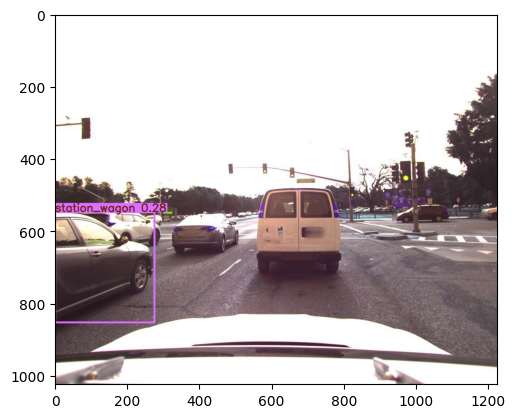

In [ ]:
#check_plotted = result_test[0].plot()
#plt.imshow(check_plotted)
#plt.show()

In [ ]:
result_test = model.predict("/content/drive/Shareddrives/ADSP Computer Vision Summer '24 Group 2/Lyft Data/sample/fff07bea08ec6f72e156facb62f9d6c5e17634fd3bdffeb3c57e4438e161ff30/host-a007_cam0_1233510592950897006.jpeg")


image 1/1 /content/drive/Shareddrives/ADSP Computer Vision Summer '24 Group 2/Lyft Data/sample/fff07bea08ec6f72e156facb62f9d6c5e17634fd3bdffeb3c57e4438e161ff30/host-a007_cam0_1233510592950897006.jpeg: 192x224 1 station_wagon, 7.3ms
Speed: 0.8ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 192, 224)


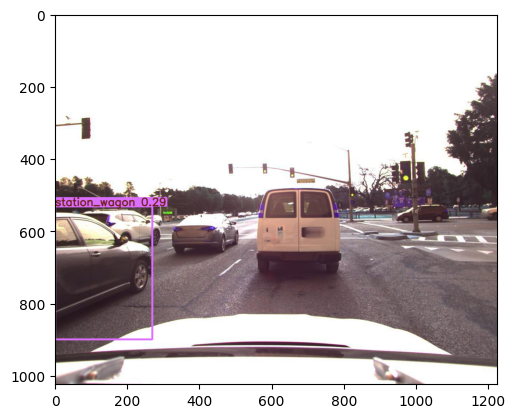

In [ ]:
check_plotted = result_test[0].plot()
plt.imshow(check_plotted)
plt.show()

# Choosing Validation Set for Classification Label in RoboFlow

In [ ]:
# randomly select images from lyft dataset that will be put into a label validation folder. I will then label those 100 images in Roboflow to have a test set for the custom yolo model

In [ ]:
base_dir = "/content/drive/Shareddrives/ADSP Computer Vision Summer '24 Group 2/Lyft Data"  # Change to your actual path
destination_dir = "/content/drive/Shareddrives/ADSP Computer Vision Summer '24 Group 2/Lyft Data/yolo_labeled_validation"

In [ ]:
os.makedirs(destination_dir, exist_ok=True)

In [ ]:
all_image_paths = []

In [ ]:
for root, dirs, files in os.walk(base_dir):
    for file in files:
        # Check if the file is an image
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff', '.tif')):
            full_path = os.path.join(root, file)
            all_image_paths.append(full_path)


In [ ]:
selected_images = random.sample(all_image_paths, 100)

In [ ]:
for image_path in selected_images:
    shutil.copy(image_path, destination_dir)

In [ ]:
output_file_path = os.path.join(destination_dir, 'copied_image_paths.txt')
with open(output_file_path, 'w') as file:
    for image_path in selected_images:
        file.write(f"{image_path}\n")

print(f"Successfully copied 100 images to {destination_dir} and listed their paths in 'copied_image_paths.txt'.")

Successfully copied 100 images to /content/drive/Shareddrives/ADSP Computer Vision Summer '24 Group 2/Lyft Data/yolo_labeled_validation and listed their paths in 'copied_image_paths.txt'.


# Comparing YOLO to Cars Dataset (Validation)

In [ ]:
## Dont Run
import os
from PIL import Image

def check_images(directory):
    corrupt_images = []
    for subdir, _, files in os.walk(directory):
        for file in files:
            try:
                img_path = os.path.join(subdir, file)
                img = Image.open(img_path)
                img.verify()
            except (IOError, SyntaxError) as e:
                print(f"Corrupt image found: {img_path}")
                corrupt_images.append(img_path)
    return corrupt_images

train_images_path = '/content/drive/Shareddrives/ADSP Computer Vision Summer \'24 Group 2/Car Data/train/images'
val_images_path = '/content/drive/Shareddrives/ADSP Computer Vision Summer \'24 Group 2/Car Data/val/images'

corrupt_train_images = check_images(train_images_path)
corrupt_val_images = check_images(val_images_path)

print(f"Corrupt train images: {len(corrupt_train_images)}")
print(f"Corrupt val images: {len(corrupt_val_images)}")


Corrupt train images: 0
Corrupt val images: 0


In [ ]:
## Dont Run
def check_labels(image_dir, label_dir):
    for class_folder in os.listdir(image_dir):
        image_class_path = os.path.join(image_dir, class_folder)
        label_class_path = os.path.join(label_dir, class_folder)

        if not os.path.isdir(image_class_path):
            continue

        images = [os.path.splitext(f)[0] for f in os.listdir(image_class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
        labels = [os.path.splitext(f)[0] for f in os.listdir(label_class_path) if f.endswith('.txt')]

        missing_labels = set(images) - set(labels)
        missing_images = set(labels) - set(images)

        if missing_labels:
            print(f"Missing labels for images in {class_folder}: {missing_labels}")
        if missing_images:
            print(f"Missing images for labels in {class_folder}: {missing_images}")

train_labels_path = '/content/drive/Shareddrives/ADSP Computer Vision Summer \'24 Group 2/Car Data/train/labels'
val_labels_path = '/content/drive/Shareddrives/ADSP Computer Vision Summer \'24 Group 2/Car Data/val/labels'

check_labels(train_images_path, train_labels_path)
check_labels(val_images_path, val_labels_path)


In [ ]:
# Dont Run
results = check.val()

Ultralytics YOLOv8.2.75 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)


val: Scanning /content/drive/Shareddrives/ADSP Computer Vision Summer '24 Group 2/Car Data/val/labels/hatchback.cache... 1920 images, 0 backgrounds, 5 corrupt: 100%|██████████| 1920/1920 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/drive/Shareddrives/ADSP Computer Vision Summer '24 Group 2/Car Data/val/images/hatchback/150_388_2009_19ba945586e9c1.jpg: ignoring corrupt image/label: negative label values [         -1]
val: WARNING ⚠️ /content/drive/Shareddrives/ADSP Computer Vision Summer '24 Group 2/Car Data/val/images/sedan/73_443_2015_a13407a1053b6a.jpg: ignoring corrupt image/label: negative label values [         -1]
val: WARNING ⚠️ /content/drive/Shareddrives/ADSP Computer Vision Summer '24 Group 2/Car Data/val/images/sports_convertible/143_1838_2014_c790b40e896ad4.jpg: ignoring corrupt image/label: negative label values [         -1]
val: WARNING ⚠️ /content/drive/Shareddrives/ADSP Computer Vision Summer '24 Group 2/Car Data/val/images/sports_convertible/48_317_2014_c17ff60feded5a.jpg: ignoring corrupt image/label: negative label values [         -1]
val: WARNING ⚠️ /content/drive/Shareddrives/ADSP Computer Vision Summer '24 Group 2/Car Data/val/images/sports_convertible/4_512_2015_c


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 120/120 [05:27<00:00,  2.73s/it]


                   all       1915       1915      0.981      0.976      0.992      0.983
                 sedan        263        263      0.989      0.984      0.994       0.98
             hatchback        211        211          1      0.995      0.995      0.987
         suv_crossover        356        356      0.949      0.955      0.984      0.973
                pickup        667        667       0.98      0.968      0.992      0.988
         station_wagon        418        418      0.986       0.98      0.993       0.99
Speed: 0.1ms preprocess, 0.9ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/val2


In [ ]:
results = model.val()

Ultralytics YOLOv8.2.76 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)


val: Scanning /content/drive/Shareddrives/ADSP Computer Vision Summer '24 Group 2/Car Data/val/labels/hatchback.cache... 1920 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1920/1920 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 120/120 [00:11<00:00, 10.29it/s]


                   all       1920       1920      0.853      0.842      0.907      0.895
               minibus        240        240      0.965      0.916       0.98      0.963
                 sedan        240        240      0.775      0.734      0.853      0.841
             hatchback        240        240      0.746      0.621      0.765      0.757
         suv_crossover        240        240      0.817      0.867      0.905      0.889
                pickup        240        240      0.981      0.963      0.988      0.982
         station_wagon        240        240      0.905      0.948      0.966      0.951
              mini_van        240        240      0.767      0.817      0.871      0.866
    sports_convertible        240        240      0.871      0.875      0.928      0.909
Speed: 0.0ms preprocess, 1.5ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/train312


# Comparing YOLO to Lyft Classification Validation (labeled in RoboFlow)

In [ ]:
# run the yolo model for object detection and car classification on the labeled dataset in roboflow (val) set

In [ ]:
import os
import locale

os.environ["PYTHONIOENCODING"] = "utf-8"
os.environ["LANG"] = "en_US.UTF-8"
os.environ["LC_ALL"] = "en_US.UTF-8"

# Try to set the locale
try:
    locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')
except locale.Error:
    print("Failed to set locale")

print("After setting environment variables:")
print("Locale from getlocale():", locale.getlocale())
print("Preferred encoding:", locale.getpreferredencoding())
print("Default encoding:", locale.getdefaultlocale())

After setting environment variables:
Locale from getlocale(): ('en_US', 'UTF-8')
Preferred encoding: ANSI_X3.4-1968
Default encoding: ('en_US', 'UTF-8')


In [ ]:
!pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.2 MB/s eta 0:00:00
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling chardet-5.2.0:
      Successfully uninstalled chardet-5.2.0


In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="WF7xBxU0T926QgRWGrKL")
project = rf.workspace("cvfinalproject-vqpwi").project("label_cars-2hmyz")
version = project.version(1)
dataset = version.download("yolov8")


loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.2.76, to fix: `pip install ultralytics==8.0.196`


In [ ]:
###### Dont Run
model = YOLO('yolo_custom.pt')

In [ ]:
dataset.location

"/content/drive/Shareddrives/ADSP Computer Vision Summer '24 Group 2/Car Data/label_cars-1"

In [ ]:
import os
import numpy as np

# Define paths
validation_images_path = os.path.join(dataset.location, 'valid', 'images')

image_paths = []
for subdir, _, files in os.walk(validation_images_path):
    for file in files:
        if file.endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(os.path.join(subdir, file))

# Initialize lists for predictions and ground truths
all_predictions = []
all_ground_truths = []

for img_path in image_paths:
    # Run predictions
    results = model.predict(img_path)

    # Collect predictions
    predicted_classes = results[0].boxes.cls.cpu().numpy()

    # Load corresponding ground truth labels
    label_path = img_path.replace('images', 'labels').replace('.jpg', '.txt').replace('.jpeg', '.txt').replace('.png', '.txt')

    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            ground_truth_classes = [int(line.split()[0]) for line in f.readlines()]

        # Check if the number of predictions matches the number of ground truths
        if len(predicted_classes) == len(ground_truth_classes):
            all_predictions.extend(predicted_classes)
            all_ground_truths.extend(ground_truth_classes)
        else:
            print(f"Warning: Mismatch in number of predictions and ground truths for {img_path}")
    else:
        print(f"Warning: Label file not found for {img_path}")

# Convert to numpy arrays
all_predictions = np.array(all_predictions)
all_ground_truths = np.array(all_ground_truths)



image 1/1 /content/drive/Shareddrives/ADSP Computer Vision Summer '24 Group 2/Car Data/label_cars-1/valid/images/02b9e104d4867ae60c4ab4973880d042da096db610ae4b22ec3c0cd041116b53_host-a007_cam3_1233510219700869006_jpeg_jpg.rf.54d6d53f4f87a8ac282fdea0b51c6828.jpg: 224x224 1 pickup, 99.8ms
Speed: 1.8ms preprocess, 99.8ms inference, 8.4ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /content/drive/Shareddrives/ADSP Computer Vision Summer '24 Group 2/Car Data/label_cars-1/valid/images/39437cc48a7a9f010151131ca5ed4e17806765d4f08e60856a57c735f1914b80_host-a004_cam3_1232905202900897006_jpeg_jpg.rf.083394517a28d38b6a8ec687fef6b215.jpg: 224x224 (no detections), 137.4ms
Speed: 1.2ms preprocess, 137.4ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /content/drive/Shareddrives/ADSP Computer Vision Summer '24 Group 2/Car Data/label_cars-1/valid/images/44968fa21786dd9885268125da77970cc7e29e6a03a52f8bc51c64fde12dc1bb_host-a004_cam3_1233444836300897006_jpeg_

In [ ]:
from sklearn.metrics import f1_score, accuracy_score, classification_report

# Convert lists to numpy arrays
all_predictions = np.array(all_predictions)
all_ground_truths = np.array(all_ground_truths)

# Calculate F1 Score
f1 = f1_score(all_ground_truths, all_predictions, average='weighted')

# Calculate Accuracy
accuracy = accuracy_score(all_ground_truths, all_predictions)

# Output metrics
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

F1 Score: 0.37834467120181403
Accuracy: 0.38095238095238093


In [ ]:
all_predictions

array([          7,           7,           2,           6,           3,           7,           3,           4,           7,           6,           3,           6,           7,           3,           2,           1,           7,           7,           7,           5,           1,           7,           1,           3],
      dtype=float32)

In [ ]:
all_ground_truths

array([5, 4, 4, 1, 5, 4, 5, 1, 5, 5, 2, 4, 4, 5, 4, 4, 2, 1, 4, 4, 4, 4, 4, 5])

In [ ]:
unique_ground_truths = np.unique(all_ground_truths)
unique_predictions = np.unique(all_predictions)

print("Unique classes in ground truths:", unique_ground_truths)
print("Unique classes in predictions:", unique_predictions)
print("Total number of classes in the model:", len(model.names))

Unique classes in ground truths: [0 1 2 3 4 6]
Unique classes in predictions: [          1           2           3           4           5]
Total number of classes in the model: 8


In [ ]:
present_classes = sorted(set(unique_ground_truths) | set(unique_predictions))

# Get the corresponding class names
present_class_names = [model.names[i] for i in present_classes]

# Calculate the classification report
class_report = classification_report(all_ground_truths, all_predictions, target_names=present_class_names, labels=present_classes)

# Output the classification report
print("\nClassification Report:\n", class_report)



Classification Report:
                precision    recall  f1-score   support

      minibus       0.00      0.00      0.00         0
        sedan       0.00      0.00      0.00         3
    hatchback       0.00      0.00      0.00         1
suv_crossover       0.14      1.00      0.25         1
       pickup       0.57      0.50      0.53         8
station_wagon       0.50      0.38      0.43         8
     mini_van       0.00      0.00      0.00         0

    micro avg       0.38      0.38      0.38        21
    macro avg       0.17      0.27      0.17        21
 weighted avg       0.41      0.38      0.38        21



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


In [ ]:
report_dict = classification_report(all_ground_truths, all_predictions, target_names=present_class_names, labels=present_classes, output_dict=True)

# Convert the report dictionary to a pandas DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Rename the index to have a more presentation-friendly format
report_df.index.name = 'Class'
report_df.reset_index(inplace=True)

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variabl

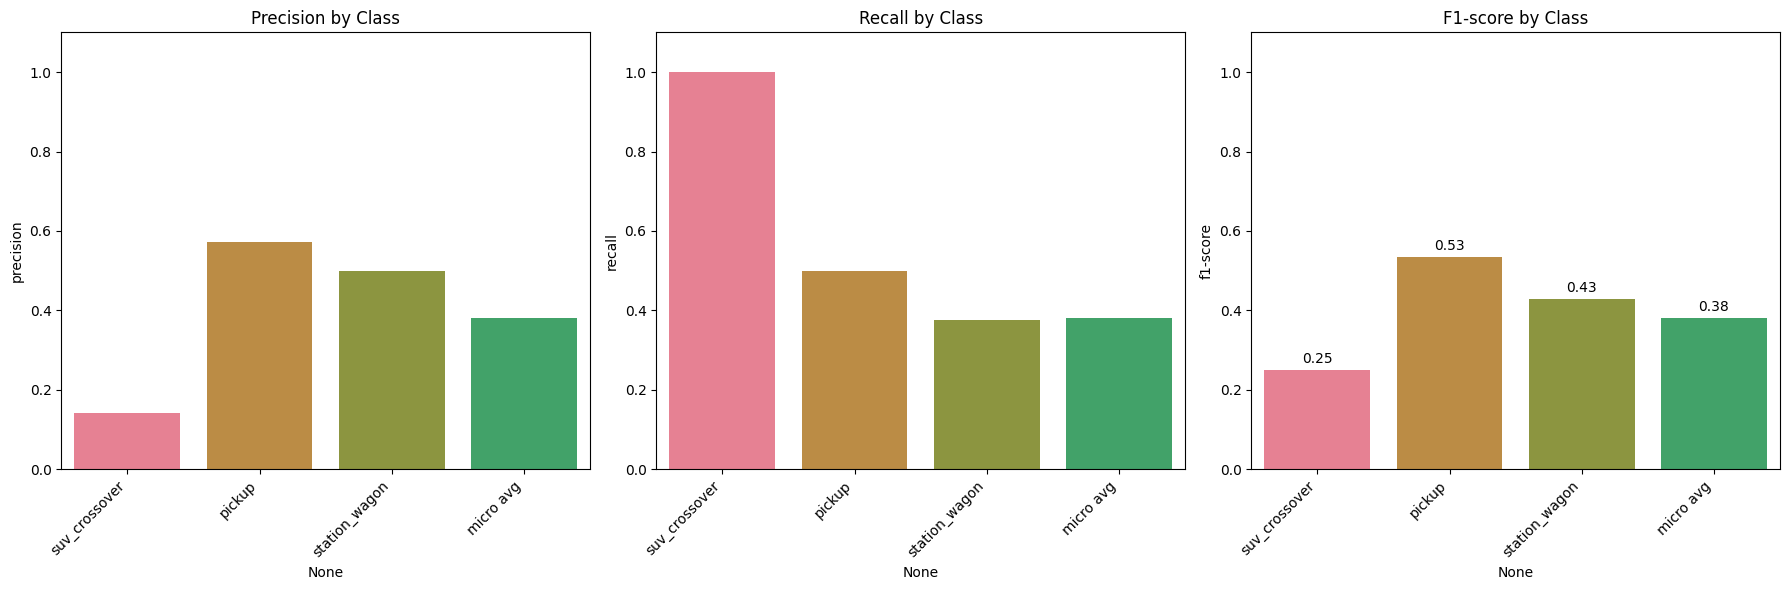

In [ ]:
def visualize_report(report):
    # Define custom colors
    colors = sns.color_palette("husl", len(report) - 2)  # Exclude 'accuracy', 'macro avg', and 'weighted avg'

    # Extracting metrics for each class
    metrics = ['precision', 'recall', 'f1-score']
    data = {metric: [] for metric in metrics}
    labels = []

    # Include class-specific metrics
    for cls, metrics_values in report.items():
        if cls not in ['accuracy', 'macro avg', 'weighted avg']:
            # Check if there are non-zero values in the metrics for this class
            has_non_zero_values = any(metrics_values.get(metric, 0) > 0 for metric in metrics)
            if has_non_zero_values:
                labels.append(cls)
                for metric in metrics:
                    data[metric].append(metrics_values.get(metric, 0))

    # Convert data to DataFrame for easy plotting
    df = pd.DataFrame(data, index=labels)

    # Creating subplots for each metric
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    for ax, metric in zip(axes, metrics):  # Include 'precision', 'recall', 'f1-score'
        sns.barplot(ax=ax, x=df.index, y=metric, data=df, palette=colors)
        ax.set_title(f'{metric.capitalize()} by Class')
        ax.set_ylim(0, 1.1)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

    for i in ax.containers:
        ax.bar_label(i, fmt='%.2f', label_type='edge', fontsize=10, padding=3)


    plt.tight_layout()
    plt.show()

# Convert the classification report to dictionary format
report_dict = classification_report(all_ground_truths, all_predictions, target_names=present_class_names, labels=present_classes, output_dict=True)

# Visualize the report
visualize_report(report_dict)


image 1/1 /content/drive/Shareddrives/ADSP Computer Vision Summer '24 Group 2/Car Data/label_cars-1/valid/images/ddd0a8776e5dce152c863664ac2ff058698111a772401417ef3752f46b2d3459_host-a007_cam5_1233510217167475006_jpeg_jpg.rf.732f47be8725092e99d25cf5c0fc432c.jpg: 224x224 1 suv_crossover, 62.2ms
Speed: 1.2ms preprocess, 62.2ms inference, 1.4ms postprocess per image at shape (1, 3, 224, 224)


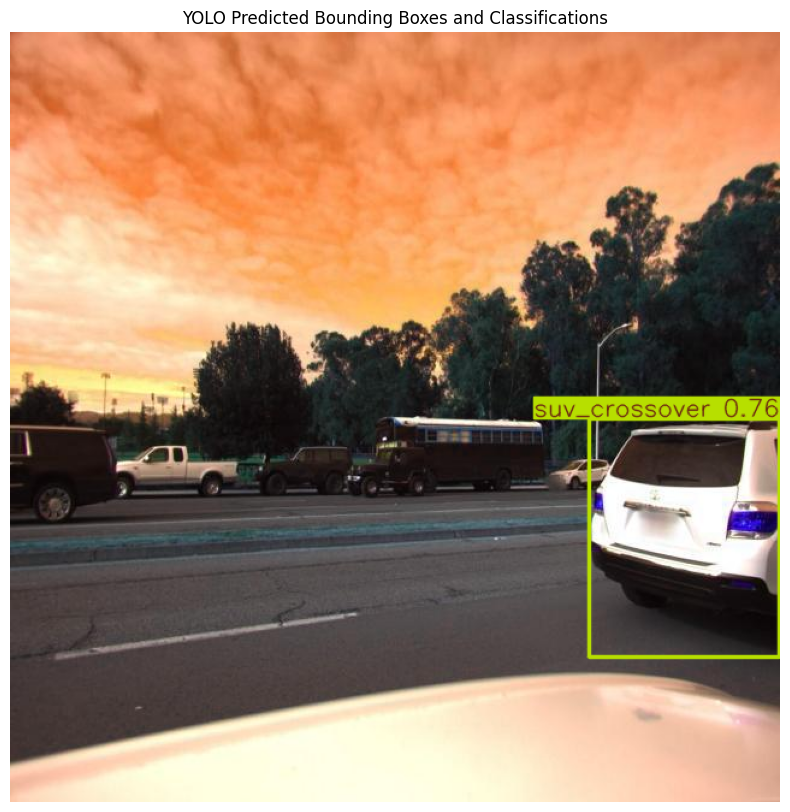

In [ ]:
example_image_path = image_paths[9]  # Replace with the desired image index

# Run prediction on the example image
results = model.predict(example_image_path)

# Draw the predicted bounding boxes and classifications on the image
predicted_image = results[0].plot()  # This creates an image with predictions drawn

# Display the image with predicted bounding boxes and classifications
plt.figure(figsize=(10, 10))
plt.imshow(predicted_image)
plt.title("YOLO Predicted Bounding Boxes and Classifications")
plt.axis('off')
plt.show()


image 1/1 /content/label_cars-1/valid/images/host-a004_cam4_1232815269084193006_jpeg.rf.ba0be2cea10240510e9bea8c59ea014f.jpg: 224x224 1 suv_crossover, 20.5ms
Speed: 7.3ms preprocess, 20.5ms inference, 2.2ms postprocess per image at shape (1, 3, 224, 224)


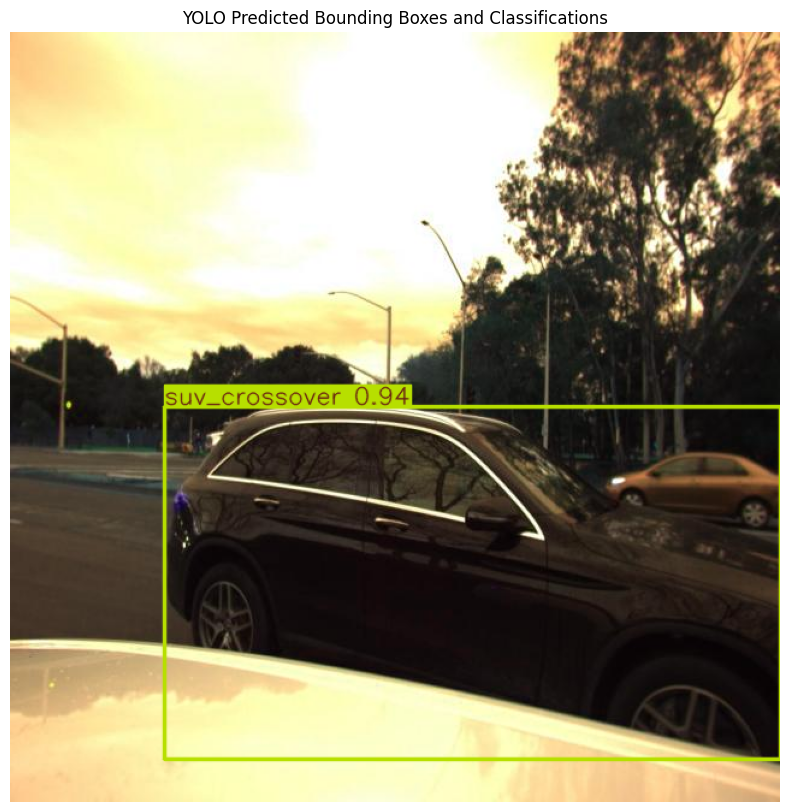

In [ ]:
### Dont Run
example_image_path = image_paths[0]  # Replace with the desired image index

# Run prediction on the example image
results = model.predict(example_image_path)

# Draw the predicted bounding boxes and classifications on the image
predicted_image = results[0].plot()  # This creates an image with predictions drawn

# Display the image with predicted bounding boxes and classifications
plt.figure(figsize=(10, 10))
plt.imshow(predicted_image)
plt.title("YOLO Predicted Bounding Boxes and Classifications")
plt.axis('off')
plt.show()

# YOLO Model 2: Train YOLO on RoboFlow labeled dataset for ONLY Object Detection in Lyft Dashcam Images

In [ ]:
# load in Object labeled dataset from RoboFlow (~700 images)

In [ ]:
from roboflow import Roboflow

rf = Roboflow(api_key="OATx3ae0SCfSUDHx8AAp")
project = rf.workspace("cv-final-project-lyft-labeling").project("lyft-vehicle-detection")
version = project.version(1)

loading Roboflow workspace...
loading Roboflow project...


In [ ]:
dataset = version.download("yolov8-obb")

In [ ]:
# Load and Train base YOLOv8n on the labeled Lyft dashcam images

In [ ]:
model = YOLO('yolov8n.pt')

100%|██████████| 6.25M/6.25M [00:00<00:00, 57.8MB/s]


In [ ]:
yaml_file_path = f"{dataset.location}/data.yaml"
with open(yaml_file_path, 'r') as file:
    yaml_content = file.read()

print(yaml_content)

path: /content/Lyft-Vehicle-Detection-1/

train: train/images
val: valid/images

names: 
  0: cars


In [ ]:
model.train(
    data='/content/Lyft-Vehicle-Detection-1/data.yaml',  # Path to the data.yaml file downloaded by Roboflow,  # Path to the data.yaml file downloaded by Roboflow
    epochs=3,                             # Number of epochs, adjust as needed
    batch=16,                              # Batch size, adjust based on your GPU capacity
    imgsz=640
)

Ultralytics YOLOv8.2.75 🚀 Python-3.10.12 torch-2.3.1+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/Lyft-Vehicle-Detection-1/data.yaml, epochs=3, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_con

train: Scanning /content/Lyft-Vehicle-Detection-1/train/labels.cache... 413 images, 0 backgrounds, 0 corrupt: 100%|██████████| 413/413 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/Lyft-Vehicle-Detection-1/valid/labels.cache... 103 images, 0 backgrounds, 0 corrupt: 100%|██████████| 103/103 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train
Starting training for 3 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/3         0G      1.928      1.857      1.577         55        640: 100%|██████████| 26/26 [07:39<00:00, 17.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:37<00:00,  9.30s/it]

                   all        103        375      0.638     0.0267      0.054     0.0233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/3         0G      1.232      1.238      1.142        105        640: 100%|██████████| 26/26 [08:12<00:00, 18.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:30<00:00,  7.62s/it]

                   all        103        375      0.788      0.248      0.366      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/3         0G      1.091      1.121      1.085         67        640: 100%|██████████| 26/26 [06:22<00:00, 14.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:30<00:00,  7.52s/it]

                   all        103        375      0.718      0.632      0.729      0.501



3 epochs completed in 0.402 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.75 🚀 Python-3.10.12 torch-2.3.1+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:34<00:00,  8.56s/it]


                   all        103        375      0.719      0.632      0.729        0.5
Speed: 5.1ms preprocess, 278.2ms inference, 0.0ms loss, 10.1ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7836ceeb7fd0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [ ]:
# validate results

In [ ]:
results = model.val()

Ultralytics YOLOv8.2.75 🚀 Python-3.10.12 torch-2.3.1+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/Lyft-Vehicle-Detection-1/valid/labels.cache... 103 images, 0 backgrounds, 0 corrupt: 100%|██████████| 103/103 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:29<00:00,  4.19s/it]


                   all        103        375       0.73      0.634      0.729      0.502
Speed: 3.3ms preprocess, 240.3ms inference, 0.0ms loss, 6.2ms postprocess per image
Results saved to runs/detect/train


In [ ]:
shutil.move("/content/runs", "/content/drive/Shareddrives/ADSP Computer Vision Summer \'24 Group 2/Lyft Data/")

"/content/drive/Shareddrives/ADSP Computer Vision Summer '24 Group 2/Lyft Data/runs"

In [ ]:
val_images_path = "/content/drive/Shareddrives/ADSP Computer Vision Summer \'24 Group 2/Lyft Data/Car Labeling.v1i.coco/valid"

coco_annotation_file = "/content/drive/Shareddrives/ADSP Computer Vision Summer \'24 Group 2/Lyft Data/Car Labeling.v1i.coco/valid/_annotations.coco.json"

# Load the COCO dataset
coco = COCO(coco_annotation_file)

# Choose an image to visualize
example_image_name = "host-a101_cam0_1242749266549230006_jpeg.rf.679d0bd6e92b8297bd3176e715bc1c6d.jpg"  # Replace with an actual image name from the validation set
example_image_path = f"{val_images_path}/{example_image_name}"

loading annotations into memory...
Done (t=0.34s)
creating index...
index created!


In [ ]:
# output example image of trained YOLO bounding box predictions vs ground truth labeled RoboFlow bounding boxes

In [ ]:
print(example_image_path)

/content/drive/Shareddrives/ADSP Computer Vision Summer '24 Group 2/Lyft Data/Car Labeling.v1i.coco/valid/host-a101_cam0_1242749266549230006_jpeg.rf.679d0bd6e92b8297bd3176e715bc1c6d.jpg


In [ ]:
image = cv2.imread(example_image_path)
if image is None:
    raise FileNotFoundError(f"Image not found at path {example_image_path}")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


In [ ]:
predictions = model(example_image_path)

plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
plt.axis('off')

if len(predictions[0].boxes) > 0:
    for pred in predictions[0].boxes.xyxy:
        x_min, y_min, x_max, y_max = pred[:4].cpu().numpy()
        width = x_max - x_min
        height = y_max - y_min
        plt.gca().add_patch(Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none', label='Prediction'))
else:
    print("No predictions made by the model.")

# Get the image ID from COCO annotations
image_ids = coco.getImgIds()
image_id = None
for img_id in image_ids:
    img_info = coco.loadImgs(img_id)[0]
    if img_info['file_name'] == example_image_name:
        image_id = img_id
        break

if image_id is None:
    raise ValueError(f"Image ID for {example_image_name} not found in COCO annotations.")

# Load the annotations for this image
annotations = coco.loadAnns(coco.getAnnIds(imgIds=[image_id]))

# Plot ground truth bounding boxes (in green)
for ann in annotations:
    x_min, y_min, width, height = ann['bbox']
    plt.gca().add_patch(Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='g', facecolor='none', label='Ground Truth'))

plt.title("YOLO Predictions (Red) vs Ground Truth (Green)")

output_image_path = "/content/drive/Shareddrives/ADSP Computer Vision Summer \'24 Group 2/Lyft Data/yolo_v_labels.jpg"
plt.savefig(output_image_path)


image 1/1 /content/drive/Shareddrives/ADSP Computer Vision Summer '24 Group 2/Lyft Data/Car Labeling.v1i.coco/valid/host-a101_cam0_1242749266549230006_jpeg.rf.679d0bd6e92b8297bd3176e715bc1c6d.jpg: 384x640 5 carss, 276.5ms
Speed: 9.1ms preprocess, 276.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
